In [31]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# IMPORTING DATA PRODUCED VIA DataforProject
data_raw = pd.read_csv('data_final.csv')
data_raw = data_raw.set_index('symbol')

In [3]:
# CLEANING DATA: Removing Rows and Columns with more than 10 Null values
data_clean = data_raw[data_raw.isnull().sum(axis=1) < 10] # Remove Symbol if number of null greater than 10
data_clean = data_clean.loc[:, data_clean.isnull().sum() <= 10] # Remove columns that have more than 10 null values
data_clean['sector'] = data_clean['sector'].fillna('unknown') # Fill null sector with unknown

In [4]:
# Replace Sector Name with a numeric code
sector = data_clean.sector.unique()
sector = pd.DataFrame(sector)
sector.columns = ['sector']
sector['sector_code'] = np.arange(len(sector))

In [10]:
# Function that assigns a value 1 if the return is positive, 0 otherwise
def buy_ignore (row):
    if row['return'] > 1:
        return 1
    else:
        return 0

In [12]:
#  Create BUY-IGNORE signal, Fill others null values with column mean, Create a sub dataset with independent variables only
DATA = data_clean.reset_index().merge(sector, how="left").set_index('symbol')
DATA.drop('sector',axis='columns', inplace=True)
DATA['buy_ignore'] = DATA.apply (lambda row: buy_ignore(row), axis=1)

DATA = DATA.apply(lambda x: x.fillna(x.mean()))
DATA_INDEP = DATA.drop(['return', 'buy_ignore'], axis=1)

In [40]:
# Explore Significance of Independent Variables via the p_values results of an Ordinary Least Square Regression
X = DATA_INDEP
y = DATA['buy_ignore']
model1 = sm.OLS(y,X)
results = model1.fit()

p_values = results.pvalues
p_values = pd.DataFrame(p_values)
p_values.columns = ['p_values']

# Export p_values into an Excel
writer = pd.ExcelWriter('p_values.xlsx', engine='xlsxwriter')
p_values.to_excel(writer, sheet_name='p_values')
writer.save()

In [16]:
# Reduced list of indicators - OLS p_values less than 0.1
indicators = []
filename = 'indicators_significant.txt'
with open(filename, 'r') as f:
    for line in f:
        indicators.append(line.strip('\n'))

In [18]:
# Indepedent Variables DataFrame reduced to significant indicators only
DATA_INDEP_RED = DATA_INDEP.filter(indicators, axis=1)

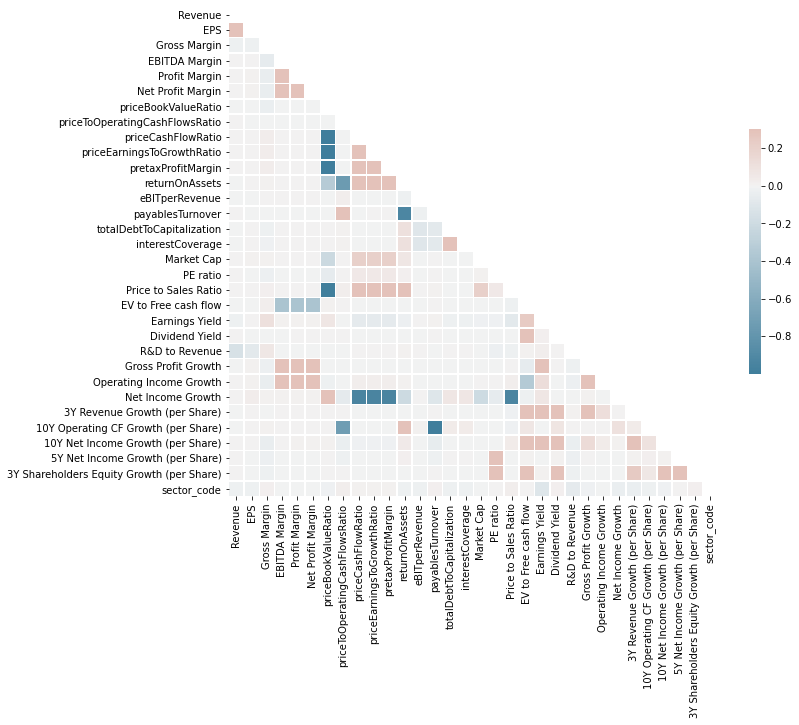

In [41]:
# CORRELATION between independent variables - Matrix
corrMatrix = DATA_INDEP_RED.corr()
corrMatrix

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});